# AI model generation script - first experiment
first install dependencies, assuming python and pip are installed:
pip install tensorflow opencv-python matplotlib
pip install notebook

largely taken from: https://www.youtube.com/watch?v=jztwpsIzEGc

In [1]:
#Import packages
import tensorflow as tf
import os
import cv2
import numpy as np

2023-08-22 12:54:36.673568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print("Hello world")

Hello world


In [9]:
#set up data
data_dir = 'carabid_data'

In [13]:
#read in a test image
img = cv2.imread(os.path.join('carabid_data','OMUDEJ','NEON.BET.D16.004349.JPG'))

In [14]:
#check image attributes
img.shape

(4000, 6000, 3)

# Import Data

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
#creating a data object
#customize image import here
#list of directories using os.listdir(data_dir)
classes=('PASCAL','OMUDEJ','PASELO','PTELAM','SCASUB')
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(400, 600), class_names=classes)

NameError: name 'data_dir' is not defined

In [46]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [48]:
os.listdir(data_dir)

['PASCAL', '.DS_Store', 'OMUDEJ', 'PASELO', 'PTELAM', 'SCASUB']

In [62]:
#creating an iterator to access data
data_iterator = data.as_numpy_iterator()

In [63]:
batch = data_iterator.next()

In [58]:
#Images represented as numpy arrays
batch[0].shape

(32, 600, 400, 3)

In [59]:
#labels of batch
batch[1]

array([2, 3, 2, 4, 0, 3, 2, 1, 2, 4, 4, 4, 3, 2, 2, 3, 4, 0, 1, 0, 4, 3,
       0, 4, 1, 1, 1, 2, 1, 1, 1, 4], dtype=int32)

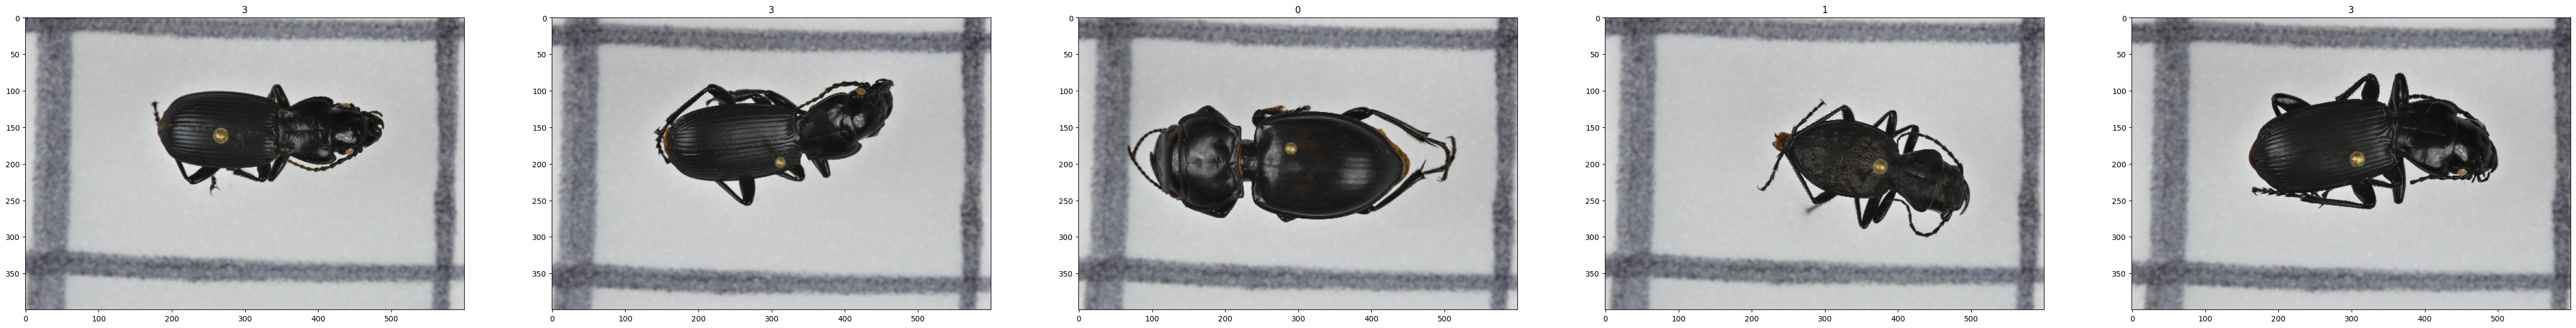

In [64]:
#Plot sample images for confirmation
fig, ax = plt.subplots(ncols=5, figsize = (60,40))
for i, img in enumerate(batch[0][:5]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

## Preprocess Data

In [69]:
# could use other scaling workflows, especially if defining trainign and validation data separately above
#tf.data.Dataset has many other options
data_scaled = data.map(lambda x,y: (x/255, y))

In [70]:
data_scaled.as_numpy_iterator().next()[0].max()

1.0

## Split Data

In [86]:
len(data_scaled)

5

In [72]:
#set number of batches
train_size = 3
val_size = 1
test_size = 1

In [85]:
#Set data partitions
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

In [75]:
len(test)

1

# Deep Model

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [90]:
#establish a model - can do inside first command or use the add method
model = Sequential()

In [91]:
model.add(Conv2D(16, (5,5), 1, activation='relu', input_shape=(400,600,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (5,5), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (5,5), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
#number of final possibilities is n-1
model.add(Dense(5, activation='softmax'))

In [92]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 396, 596, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 198, 298, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 194, 294, 32)      12832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 97, 147, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 93, 143, 64)       51264     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 46, 71, 64)       

## Train model

In [81]:
logdir = 'logs'

In [82]:
#allows for a callback ... for more complex things and restarting, I think
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [94]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 17s 5s/step - loss: 29.1293 - accuracy: 0.1354 - val_loss: 3.7109 - val_accuracy: 0.2188
Epoch 2/20
3/3 [==============================] - 16s 5s/step - loss: 2.3495 - accuracy: 0.2292 - val_loss: 1.5502 - val_accuracy: 0.3438
Epoch 3/20
3/3 [==============================] - 17s 5s/step - loss: 1.5636 - accuracy: 0.2604 - val_loss: 1.9090 - val_accuracy: 0.1562
Epoch 4/20
3/3 [==============================] - 16s 5s/step - loss: 1.5334 - accuracy: 0.3333 - val_loss: 1.4014 - val_accuracy: 0.7500
Epoch 5/20
3/3 [==============================] - 16s 5s/step - loss: 1.5156 - accuracy: 0.6042 - val_loss: 1.2669 - val_accuracy: 0.6562
Epoch 6/20
3/3 [==============================] - 16s 5s/step - loss: 1.3059 - accuracy: 0.6042 - val_loss: 1.2037 - val_accuracy: 0.6875
Epoch 7/20
3/3 [==============================] - 17s 5s/step - loss: 1.0792 - accuracy: 0.7812 - val_loss: 0.9190 - val_accuracy: 0.7812
Epoch 8/20
3/3 [=================

## Plot Performance

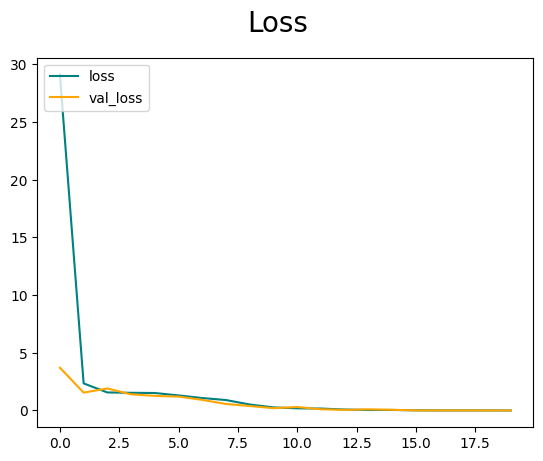

In [96]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

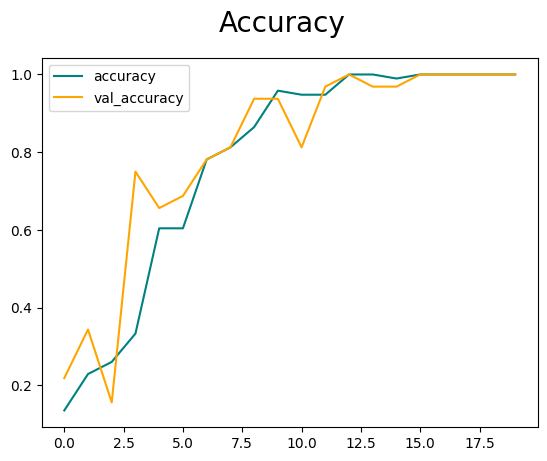

In [97]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Performance

In [98]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [99]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [113]:
 for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat = yhat.argmax(axis=-1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 174ms/step


In [114]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


## Test with new image

In [107]:
img = cv2.imread('SCASUB_unknown1.JPG')

In [108]:
resize = tf.image.resize(img, (400, 600))

In [104]:
#Expands dimensions by 1 (like the batches above) plus scales RGB values
#np.expand_dims(resize/255, 0)

In [111]:
y_prob = model.predict(np.expand_dims(resize/255, 0))
y_classes = y_prob.argmax(axis=-1)

1/1 [==============================] - 0s 87ms/step


In [116]:
y_classes[0]

4

In [117]:
print(f'Predicted taxon is: {classes[y_classes[0]]}')

Predicted taxon is: SCASUB


# Save model

In [2]:
from tensorflow.keras.models import load_model

In [129]:
#note - import of .keras file is failing, using .tf - might be a MacOS issue
model.save(os.path.join('models','five_species.tf'))

INFO:tensorflow:Assets written to: models/five_species.tf/assets


INFO:tensorflow:Assets written to: models/five_species.tf/assets


In [3]:
#load from file
new_model = load_model(os.path.join('models','five_species.tf'))

In [4]:
img = cv2.imread('NEON.BET.D08.002788_dorsal_1x.jpg')
resize = tf.image.resize(img, (400, 600))
y_prob = new_model.predict(np.expand_dims(resize/255, 0))
y_classes = y_prob.argmax(axis=-1)
classes=('PASCAL','OMUDEJ','PASELO','PTELAM','SCASUB')
print(f'Predicted taxon is: {classes[y_classes[0]]}')

1/1 [==============================] - 0s 140ms/step
Predicted taxon is: PASCAL


In [11]:
os.listdir('carabid_data')

['PASCAL', '.DS_Store', 'OMUDEJ', 'PASELO', 'PTELAM', 'SCASUB']

In [5]:
y_classes

array([0])

In [6]:
y_prob

array([[9.9871111e-01, 1.6295511e-06, 1.2810490e-03, 6.0921529e-06,
        6.8507738e-08]], dtype=float32)

In [7]:
y_prob.argmax()

0

In [15]:
y_prob[0][y_prob.argmax()]

0.9987111

In [11]:
y_prob[[0]]

array([[9.9871111e-01, 1.6295511e-06, 1.2810490e-03, 6.0921529e-06,
        6.8507738e-08]], dtype=float32)

In [14]:
y_prob[0][0]

0.9987111

In [43]:
import json
from datetime import date

In [50]:
#create dictionary of dwc terms
dwc_det = {
    "scientificName" : classes[y_prob.argmax()],
    "identifiedBy" : "AI model for carabids by M.A. Johnston",
    "dateIdentified" : date.today().strftime("%Y-%m-%d"),
    "identificationReferences" : "ID used the five_species carabid model",
    "identificationRemarks" : f'Model probability is {y_prob[0][y_prob.argmax()]}'
}


In [49]:
print(json.dumps(dwc_det, indent=4))

{
    "scientificName": "PASCAL",
    "identifiedBy": "AI model for carabids by M.A. Johnston",
    "dateIdentified": "2023-08-22",
    "identificationReferences": "ID used the five_species carabid model",
    "identificationRemarks": "Model probability is 0.998711109161377"
}
